# Writing a new data exporter

Writing a new DataExporter is very similar process to [writing a new DataLoader](https://bwheelz36.github.io/ParticlePhaseSpace/new_data_loader.html#).
As an example: lets say that I want to export some topas to the same format used in the [data import example](https://bwheelz36.github.io/ParticlePhaseSpace/new_data_loader.html#):

```
x (mm)	y (mm)	z (mm)	px (MeV/c)	py (MeV/c)	pz (MeV/c)	E (MeV)
```

> Note that these units already match those in the unit set of `mm_MeV`

To do this, we would create a data exporter as follows:

In [1]:
from pathlib import Path
import sys
sys.path.append('../')
from ParticlePhaseSpace.DataExporters import _DataExportersBase
from ParticlePhaseSpace import DataLoaders
from ParticlePhaseSpace._ParticlePhaseSpace import PhaseSpace
import numpy as np
import ParticlePhaseSpace.__particle_config__ as particle_cfg
from ParticlePhaseSpace import ParticlePhaseSpaceUnits

class NewDataExporter(_DataExportersBase):
    
    def _define_required_columns(self):
        pass
        
    def _export_data(self):
        pass
    
    def _set_expected_units(self):
        pass

Our job is to fill in these blank methods.

- in `_define_required_columns` you must list all the columns required for your data export. These column names must match  the [allowed columns](https://bwheelz36.github.io/ParticlePhaseSpace/phase_space_format.html#allowed-columns) from the phase space specification.
- in `set_expected_units` you should list the units your exporter is expecting. If the units in the data it receives are different, it will attempt to convert the data to the correct units.
- `_export_data` is where the data export will actually happen.

The filled in data exporter for the case in hand looks like this:

In [2]:
class NewDataExporter(_DataExportersBase):

    def _define_required_columns(self):
        self._required_columns = ['x', 'y', 'z', 'px', 'py', 'pz', 'Ek']
    
    def _set_expected_units(self):
        self._expected_units = ParticlePhaseSpaceUnits()('mm_MeV')
    
    
    def _export_data(self):

        if not Path(self._output_name).suffix == '.dat':
            _output_name = str(self._output_name) + '.dat'
        else:
            _output_name = self._output_name
        WritefilePath = Path(self._output_location) / _output_name

        header = 'x (mm)\ty (mm)\tz (mm)\tpx (MeV/c)\tpy (MeV/c)\tpz (MeV/c)\tE (MeV)'
        Data = [self._PS.ps_data['x [mm]'].to_numpy(), self._PS.ps_data['y [mm]'].to_numpy(), self._PS.ps_data['z [mm]'].to_numpy(),
                self._PS.ps_data['px [MeV/c]'].to_numpy(), self._PS.ps_data['py [MeV/c]'].to_numpy(),
                self._PS.ps_data['pz [MeV/c]'].to_numpy(),
                self._PS.ps_data['Ek [MeV]'].to_numpy()]
        Data = np.transpose(Data)
        FormatSpec = ['%11.5f', '%11.5f', '%11.5f', '%11.5f', '%11.5f', '%11.5f', '%11.5f']
        np.savetxt(WritefilePath, Data, fmt=FormatSpec, delimiter='      ', header=header, comments='')

## Testing the data export

Let's test the use case of loading in some topas data, and exporting it with this data exporter:

In [3]:
# load topas data:
data_loc = Path('../tests/test_data/coll_PhaseSpace_xAng_0.00_yAng_0.00_angular_error_0.0.phsp')
data = DataLoaders.Load_TopasData(data_loc)
PS = PhaseSpace(data)

# Because we only want to work with the electrons, generate an electron only phase space:
PS_electrons = PS('electrons')

NewDataExporter(PS_electrons,'.','test_new_exporter.dat')

To verify that this worked, we can recycle the [data loader]() we wrote to read this data and check if it works

In [4]:
from ParticlePhaseSpace.DataLoaders import _DataLoadersBase

class NewDataLoader(_DataLoadersBase):

    def _import_data(self):
        Data = np.loadtxt(self._input_data, skiprows=1)
        self.data['x [mm]'] = Data[:, 0]
        self.data['y [mm]'] = Data[:, 1]
        self.data['z [mm]'] = Data[:, 2]
        self.data['px [MeV/c]'] = Data[:, 3]
        self.data['py [MeV/c]'] = Data[:, 4]
        self.data['pz [MeV/c]'] = Data[:, 5]
        self.data['particle type [pdg_code]'] = particle_cfg.particle_properties[self._particle_type]['pdg_code']
        # we also need to fill in weight, particle id, and time; since none of these are specified we just use all
        # ones for weight, 1,2,3... for particle id, and all zeros for time:
        self.data['weight'] = np.ones(Data.shape[0])
        self.data['particle id'] = np.arange(len(self.data))

        self.data['time [ps]'] = 0  # may want to replace with time feature if available?

        # because we have momentum and energy, we can double check that our momentum to energy conversion is 
        # consisten with the values in the phase space:
        E = Data[:, 6]
        self._check_energy_consistency(Ek=E)

    def _check_input_data(self):
        # is the input a file?
        if not Path(self._input_data).is_file():
            raise FileNotFoundError(f'input data file {self._import_data()} does not exist')
        # does it have the right extension?
        if not Path(self._input_data).suffix == '.dat':
            raise Exception('This data loaders requires a *.dat file')
        # the header is on the first line; does it look correct?
        with open(self._input_data) as f:
            first_line = f.readline()
            if not first_line == 'x (mm)\ty (mm)\tz (mm)\tpx (MeV/c)\tpy (MeV/c)\tpz (MeV/c)\tE (MeV)\n':
                raise Exception('file header does not look correct')
        if not self._particle_type:
            raise Exception('this data loader requires particle_type to be specified')

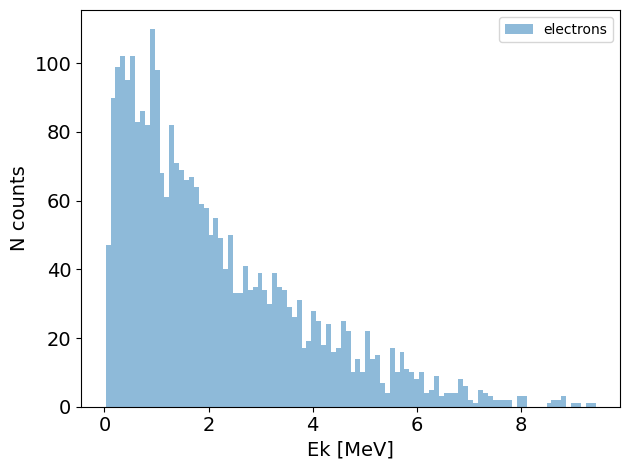

In [5]:
data_loc = 'test_new_exporter.dat'
data = NewDataLoader(data_loc, particle_type='electrons')
PS = PhaseSpace(data)
PS.plot.energy_hist_1D()

looks good!